<a href="https://colab.research.google.com/github/seanzhu815/402/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 Solution

In [163]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import modules

In [164]:
import pandas            as pd   
import numpy             as np   
import scipy             as scp  
import matplotlib.pyplot as plt  
import os                as os   
from datetime import date as dd  
from scipy import optimize
from scipy import stats
import statsmodels.api as sm

In [165]:
np.set_printoptions(precision=2) # Set precision of numpy arrays while printing uless specified otherwise
#%% Set directories and define files
os.chdir(os.path.abspath(''))   # Change directory to location of the script
datafile1 = 'drive/MyDrive/industry_returns.xlsx'

In [166]:
#%% Define helper function for Sharpe Ratio (Since this is used very frequently)
def Shratio(w,mu,Sigma,Rf): 
    portfolio_return = np.inner(mu, w) - Rf    # portfolio excess return
    portfolio_vol    = np.sqrt((w.T@Sigma@w))  # portfolio volatility
    return portfolio_return / portfolio_vol

In [167]:
#%% Read data
returns_data = pd.read_excel(datafile1, usecols = "B:M", header = 1)
dates = pd.read_excel(datafile1, usecols = "A", header = 1)
dates.columns = ['dates']
dates['dates'] = pd.to_datetime(dates['dates'],format='%Y%m')

In [6]:
# Set parameters
Rf = .04 / 12                         # monthly risk free rate
n = returns_data.shape[1]             # number of risky assets (columns)
T = returns_data.shape[0]             # number of observations (rows)
ret = returns_data/100                # convert returns from percent to decimals
mu = ret.sum()/T                      # mean returns 

In [7]:
m=[]
for i in range(12):
  m.append(returns_data.iloc[:,i])
m=np.array(m)

In [8]:
Sigma=np.cov(m)
Sigma=Sigma/100

In [9]:
Sigma

array([[0.21, 0.26, 0.25, 0.18, 0.22, 0.25, 0.14, 0.18, 0.23, 0.2 , 0.26,
        0.24],
       [0.26, 0.64, 0.45, 0.31, 0.36, 0.46, 0.23, 0.26, 0.37, 0.27, 0.42,
        0.41],
       [0.25, 0.45, 0.44, 0.3 , 0.34, 0.43, 0.21, 0.25, 0.32, 0.27, 0.39,
        0.4 ],
       [0.18, 0.31, 0.3 , 0.41, 0.24, 0.28, 0.15, 0.2 , 0.21, 0.19, 0.29,
        0.28],
       [0.22, 0.36, 0.34, 0.24, 0.32, 0.33, 0.17, 0.21, 0.26, 0.24, 0.31,
        0.3 ],
       [0.25, 0.46, 0.43, 0.28, 0.33, 0.55, 0.23, 0.25, 0.34, 0.29, 0.4 ,
        0.39],
       [0.14, 0.23, 0.21, 0.15, 0.17, 0.23, 0.21, 0.16, 0.18, 0.15, 0.22,
        0.21],
       [0.18, 0.26, 0.25, 0.2 , 0.21, 0.25, 0.16, 0.3 , 0.21, 0.19, 0.28,
        0.24],
       [0.23, 0.37, 0.32, 0.21, 0.26, 0.34, 0.18, 0.21, 0.34, 0.24, 0.32,
        0.31],
       [0.2 , 0.27, 0.27, 0.19, 0.24, 0.29, 0.15, 0.19, 0.24, 0.31, 0.28,
        0.26],
       [0.26, 0.42, 0.39, 0.29, 0.31, 0.4 , 0.22, 0.28, 0.32, 0.28, 0.46,
        0.38],
       [0.24, 0.41, 0

## Part 1

### Q 1.1

In [10]:
# Unconstrained optimization:
w0 = np.ones((n,1)) / n  # starting weights
cons = ({'type' : 'eq', 'fun': lambda x: np.sum(x) - 1}) # portfolio weights sum to 1

sol = scp.optimize.minimize(lambda w: -Shratio(w, mu, Sigma, Rf), x0 = w0, constraints = cons)
w_uncon = sol.x
val_uncon = sol.fun

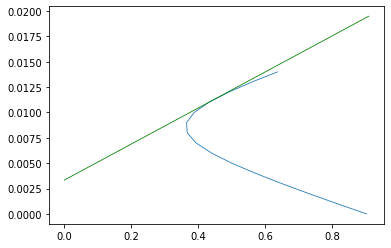

In [11]:
# Construct EML
A = (mu.T.dot(np.linalg.inv(Sigma))).dot(mu)
B = mu.T.dot(np.linalg.solve(Sigma, np.ones((n,1))))
C = np.ones((n,1)).T.dot(np.linalg.solve(Sigma, np.ones((n,1))))
mu0 = np.arange(0,.015,.001)
varR0 = (C*(mu0**2) - 2*B*mu0 + A) /( A*C-B**2)
stdR0 = np.sqrt(varR0)
dummy = np.arange(0,np.max(stdR0)+.01, .01)
Sharpe_ratio = -val_uncon                                                # From the optimization above
Line_sharpe = Rf + Sharpe_ratio * dummy
plt.plot(stdR0.reshape((mu0.shape)), mu0, linewidth = .8)
plt.plot(dummy, Line_sharpe, color = 'green', linewidth = .8)
plt.show()

### Q 1.2:

In [260]:
print(f'Annualized Sharpe ratio of tangency portfolio is {-np.sqrt(12) * val_uncon :.4}.')
print(f'Weights of tangency portfolio is {w_uncon}.')

Annualized Sharpe ratio of tangency portfolio is 0.06149.
Weights of tangency portfolio is [ 0.73  0.13 -0.05  0.29  0.03  0.17  0.23  0.05  0.09  0.33 -0.27 -0.72].


### Q 1.3:

In [261]:
# 1.3: Constrained optimization
w0 = np.ones((n,1)) / n  # starting weights
cons = ({'type' : 'eq', 'fun': lambda x: np.sum(x) - 1}) # portfolio weights sum to 1
bnds = scp.optimize.Bounds(0,.25) # upper and lower bounds

In [262]:
sol =  scp.optimize.minimize(lambda w: -Shratio(w, mu, Sigma, Rf), x0 = w0, constraints = cons,bounds=bnds)                           # Perfrom optimization here
w_con = sol.x
val_con = sol.fun
print(f'Annualized Sharpe ratio of tangency portfolio under constraints is {-np.sqrt(12) * val_con :.4}.')
print(f'Weights of tangency portfolio is {w_con}.')

Annualized Sharpe ratio of tangency portfolio under constraints is 0.05011.
Weights of tangency portfolio is [2.50e-01 0.00e+00 9.45e-17 1.84e-01 6.94e-02 1.08e-17 1.41e-01 3.45e-02
 7.12e-02 2.50e-01 7.29e-17 1.11e-16].


### Q 1.4:

In [263]:
# 1.4: Training weights (Sample upto 2009)
ret_train = ret[dates['dates'].dt.year<2010]     # Training sample
ret_test = ret[dates['dates'].dt.year>=2010]     # Testing sample
mu_train = ret_train.sum()/len(ret_train) 

In [264]:
m1=[]
for i in range(12):
  m1.append(ret_train.iloc[:,i])
m1=np.array(m1)
Sigma_train = np.cov(m1)

In [265]:
cons = ({'type' : 'eq', 'fun': lambda x: np.sum(x) - 1}) # portfolio weights sum to 1
sol = scp.optimize.minimize(lambda w: -Shratio(w, mu_train, Sigma_train, Rf), x0 = w0, constraints = cons)                             # Solve the optimization problem for training weights.
w_train = sol.x
val_train = sol.fun
print(f' Optimal portfolio weights of of training data is {w_train}.')

 Optimal portfolio weights of of training data is [ 0.81  0.06 -0.01  0.41  0.09  0.1   0.27 -0.02 -0.04  0.27 -0.25 -0.69].


In [266]:
# Test data Sharpe Ratio
mu_test =  ret_test.sum()/len(ret_test)   

m2=[]
for i in range(12):
  m2.append(ret_test.iloc[:,i])
m2=np.array(m2)                                        # mean returns of testing set
Sigma_test =  np.cov(m2)                               # covariance matrix of testing set

In [273]:
val_test = Shratio(w_train,mu_test,Sigma_test,Rf)                                       # Use the Shratio with approopriate weights
print(f'Annualized Sharpe using optimal training weights is {val_test:.4}')

Annualized Sharpe using optimal training weights is 0.136


In [272]:
# Equal weighted Sharpe Ratio
w_eq = np.ones((n)) / n  # Equal weights to all assets

val_test_eqweight=Shratio(w_eq,mu_test,Sigma_test,Rf)       # Use the Shratio with approopriate weights
print(f'Annualized Sharpe using equal weights is {val_test_eqweight:.4}')

Annualized Sharpe using equal weights is 0.1817


Thus the sharpe ratio with equal weights is better.

# Part 2: Momentum

### Q 2.1:

In [240]:
#%% Part 2: Momentum
returns = returns_data.values
T = returns.shape[0]                   # Number of time periods
n = returns.shape[1]                   # Number of assets
returns_data

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
0,1.45,15.55,3.67,-1.18,8.01,3.16,0.83,7.04,0.11,1.77,-0.02,2.22
1,3.97,3.68,2.42,3.47,5.14,1.97,2.17,-1.69,-0.71,4.25,4.47,4.34
2,1.14,4.80,-0.07,-3.39,5.30,-0.34,2.41,2.04,0.21,0.69,-1.61,0.37
3,-1.24,-8.23,-3.16,-0.78,-4.55,-5.38,-0.11,-2.63,-2.29,-0.57,-5.51,-2.73
4,5.20,-0.19,3.82,0.01,5.11,4.79,1.63,3.71,6.43,5.42,2.34,2.10
...,...,...,...,...,...,...,...,...,...,...,...,...
1148,0.40,14.67,1.20,9.83,-0.25,3.23,-2.46,9.68,2.91,5.13,-0.99,5.11
1149,2.20,-16.97,-7.92,-1.12,0.39,-12.66,-10.70,-3.71,-9.91,-6.80,-7.99,-10.29
1150,-1.68,-8.84,-0.19,15.39,-1.16,-2.16,8.54,4.79,-4.12,0.99,2.80,-2.96
1151,-3.90,-11.97,-10.06,-16.25,-8.12,-8.37,-6.72,-6.55,-7.65,-2.05,-9.05,-11.29


In [241]:
avg_ret_11months = np.ones((T,n))      # Matrix with average returns for past 11 months for n firms
winner_portfolio_ret = np.ones((T,1))  # return of the winning portfolio
loser_portfolio_ret = np.ones((T,1))
winner_ind = np.ones((T,1))            # index  of winning industry in that month
loser_ind = np.ones((T,1))

In [242]:
# loop over time series, start from 1950/01
burn = sum((dates['dates'].dt.year<1950) == True) # Number of time periods before 1950/01 that must be "burned"
burn

282

In [256]:

for i in range((burn+1),T): 
    # loop over industries
    for j in range(n):
        avg_ret_11months[i-1,j] =  np.mean(returns[i-12:i-1,j])                # take average of previous 11 months with one-skip-month
        sorted_ret = np.sort(avg_ret_11months[i-1,:])
        order = np.argsort(avg_ret_11months[i-1,:])

        long = order[-1]                        # Index of the winner industry
        short = order[0]                        # Index of the loser industry
        winner_portfolio_ret[i] = avg_ret_11months[i,long]   
        loser_portfolio_ret[i] = avg_ret_11months[i,short]
    
        winner_ind[i] = long
        loser_ind[i] = short


spread = winner_portfolio_ret - loser_portfolio_ret

In [258]:
spread.shape

(1153, 1)

In [261]:
# 2.1: Winner Minus Loser
wl_ret = pd.DataFrame(data=np.hstack((winner_portfolio_ret,loser_portfolio_ret,spread)), columns=["winner_ret", "loser_ret",'spread'])
wl_ret = wl_ret.loc[burn:]
print(f'Annualized average return for winner, loser and spread is {12*wl_ret.mean()} percent' )
print(f'Annualized standard deviation for winner, loser and spread is {np.sqrt(12)*wl_ret.std()} percent')

Annualized average return for winner, loser and spread is winner_ret    31.457961
loser_ret     -4.719553
spread        36.177514
dtype: float64 percent
Annualized standard deviation for winner, loser and spread is winner_ret    5.910767
loser_ret     5.505086
spread        5.306371
dtype: float64 percent


In [ ]:
# 2.2: Rolling time series (36 months)
wl_ret_rolling = wl_ret[["winner_ret", "loser_ret"]].rolling(36, min_periods=36).apply(lambda x: (np.prod(1.0+x/100)-1)/36*12)

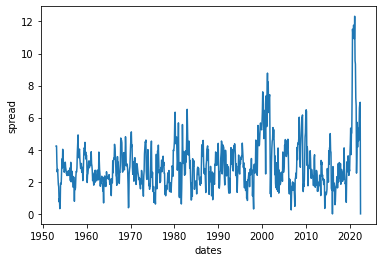

In [277]:
import seaborn as sns
wl_ret_rolling['spread'] = wl_ret['winner_ret']-wl_ret['loser_ret']                        # Calculate the rolling spread
wl_ret_rolling['dates'] = dates[(burn+36):]
sns.lineplot(data=wl_ret_rolling,x='dates',y='spread',)                                       # Plot the spread

### Q 2.3:

In [278]:
# 2.3: Winner industries
winner_ind_df = pd.DataFrame(data= winner_ind[(burn+1):], columns=['industry'])
winner_count = winner_ind_df['industry'].value_counts() #number of times in winner portfolio
winner_order = returns_data.columns[winner_count.index.astype(int)].to_list()
print(f'From most often to least ofter, winner portfolio consists of {winner_order}' )

From most often to least ofter, winner portfolio consists of ['Enrgy', 'Durbl', 'Hlth ', 'BusEq', 'Telcm', 'Money', 'Shops', 'Utils', 'NoDur', 'Other', 'Chems', 'Manuf']


### Q 2.4: Do this yourself

In [279]:
# 2.3: Loser industries
loser_ind_df = pd.DataFrame(data= loser_ind[(burn+1):], columns=['industry'])
loser_count = loser_ind_df['industry'].value_counts() #number of times in loser portfolio
loser_order = returns_data.columns[loser_count.index.astype(int)].to_list()
print(f'From most often to least ofter, loser portfolio consists of {loser_order}' )

From most often to least ofter, loser portfolio consists of ['Enrgy', 'Telcm', 'BusEq', 'Durbl', 'Utils', 'Hlth ', 'Money', 'NoDur', 'Other', 'Shops', 'Chems', 'Manuf']


### Q 2.5:

In [ ]:
# 2.5: Turnover
winner_turn = # Time series of number of 0 or 1. 1 if the winner changed from last time period
loser_turn =  # Same for loser
turnover_rate = sum(winner_turn|loser_turn)/(T-12)
print(f'frequency that either winner or loser portfolio changes is {turnover_rate:.4}' )


frequency that either winner or loser portfolio changes is 0.3883


### Q 2.6: Do this yourself

### Q 2.7

In [ ]:
# 2.7: Alpha
factors = pd.read_excel(datafile1, usecols = "O:Q", header = 1) #3 factors
#Rf = pd.read_excel(datafile1, usecols = "R", header = 0) #risk free rate
factors = factors[burn:] #3 factor

# spread
mod = sm.OLS(wl_ret['spread'],sm.add_constant( factors))
res = mod.fit()
res.summary()
print(f'alpha of wml is { res.params.const:.4}' )

# winner
mod = # Fill in the model
res = mod.fit()
res.summary()
print(f'alpha of winner is { res.params.const:.4}' )

# loser
mod = # Fill in the model
res = mod.fit()
res.summary()
print(f'alpha of loser is { res.params.const:.4}' )


alpha of wml is 1.025
alpha of winner is 0.9281
alpha of loser is -0.09701


c:\Users\anind\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
c:\Users\anind\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
c:\Users\anind\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
